In [2]:
import numpy as np
import netCDF4 as nc
import scipy.io as sio
import xarray as xr

This part of the code takes the hourly Z500 data and computes the mean and standard deviation for normalization 

It takes each netCDF file as one entry to a file list to facilitate memory optimization 

In this [paper](https://gmd.copernicus.org/preprints/gmd-2021-71/) year 1979-2017 is taken together, where 1979-2016 is used as training and 2017 as validation. 

In this example, we have changed the validation set slightly. It would not affect the performance. 



In [4]:
file=nc.Dataset('/global/cscratch1/sd/ashesh/MyQuota/ERA5/ERA_Z500_1hour.nc')
Z=np.asarray(file['input'])
M=np.mean(Z.flatten())
sdev=np.std(Z.flatten())

In [2]:
fileList_train = []
fileList_test=[]
for i in range (1979,2017):
    fileList_train.append ('/global/cscratch1/sd/ashesh/MyQuota/ERA5/geopotential_500hPa_' + str(i)+'_5.625deg.nc')

fileList_test.append('/global/cscratch1/sd/ashesh/MyQuota/ERA5/geopotential_500hPa_2018_5.625deg.nc')

In [3]:
preview_file = nc.Dataset(f'C:/Users/Aviral/DDWP-DA/dataset/geopotential_500hPa_2018_5.625deg.nc')
#print(np.asarray(preview_file['z']))
M = np.mean(np.asarray(preview_file['z']))
sdev = np.std(np.asarray(preview_file['z']))
print("Mean = ", M)
print("std dev = ", sdev)
#Z_prev = np.asarray(preview_file['input'])
#Z_prev

Mean =  54195.613
std dev =  3350.889


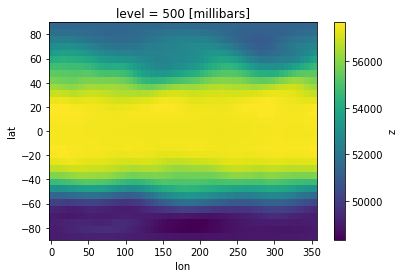

In [17]:
import matplotlib.pyplot as plt
z500 = xr.open_mfdataset(f'C:/Users/Aviral/DDWP-DA/dataset/geopotential_500hPa_2018_5.625deg.nc', combine='by_coords')
#z500.z.isel(time=0).plot();
climatology = z500.sel(time=slice('2018', '2018')).mean('time').load()
climatology.z.plot();

In [16]:
fileList_train = []
fileList_test=[]
for i in range (1979,2017):
    
    fileList_train.append (f'C:/Users/Aviral/DDWP-DA/dataset/geopotential_500hPa_' + str(i)+'_5.625deg.nc')

fileList_test.append(f'C:/Users/Aviral/DDWP-DA/dataset/geopotential_500hPa_2018_5.625deg.nc')

In [5]:
import tensorflow
import keras.backend as K
#from data_manager import ClutteredMNIST
#from visualizer import plot_mnist_sample
#from visualizer import print_evaluation
#from visualizer import plot_mnist_grid
import netCDF4
import numpy as np
from keras.layers import Input, Convolution2D, Convolution1D, MaxPooling2D, Dense, Dropout, \
                          Flatten, concatenate, Activation, Reshape, \
                          UpSampling2D,ZeroPadding2D
import keras
from keras.callbacks import History
history = History()

import keras
from keras.layers import Conv2D, Conv2DTranspose, Cropping2D, Concatenate, ZeroPadding2D
from keras.models import load_model
from keras.layers import Input
from keras.models import Model
from keras.layers import Activation
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

from utils import get_initial_weights
from layers import BilinearInterpolation

__version__ = 0.1 

We have defined the model as "stn" where "stn" includes an U-NET with a spatial transformer module that includes an affine transformation and Biliniear interpolation

In [7]:
## border_mode --> padding

def stn(input_shape=(32, 64, 1), sampling_size=(8, 16), num_classes=10):
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2,2), padding='same')(conv1)

    conv2 = Conv2D(32, (5, 5), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2,2), padding='same')(conv2)

    conv3 = Conv2D(32, (5, 5), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv3)


    conv5 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv3)
    conv5 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv5)
    
    locnet = Flatten()(conv5)
    locnet = Dense(500)(locnet)
    locnet = Activation('relu')(locnet)
    locnet = Dense(200)(locnet)
    locnet = Activation('relu')(locnet)
    locnet = Dense(100)(locnet)
    locnet = Activation('relu')(locnet)
    locnet = Dense(50)(locnet)
    locnet = Activation('relu')(locnet)
    weights = get_initial_weights(50)
    locnet = Dense(6, weights=weights)(locnet)
    x = BilinearInterpolation(sampling_size)([inputs, locnet])


    up6 = keras.layers.Concatenate(axis=-1)([Conv2D(32, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(x)), conv2])
    conv6 = Conv2D(32, (5, 5), activation='relu', padding='same')(up6)
    conv6 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv6)

    up7 = keras.layers.Concatenate(axis=-1)([Conv2D(32, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6)), conv1])
    conv7 = Conv2D(32, (5, 5), activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv7)



    conv10 = Conv2D(1, (5, 5), activation='linear',padding='same')(conv7)

    model = Model(inputs=inputs, outputs=conv10)



    return model

In [14]:
inputs = Input(shape=(32, 64, 1))
conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2,2), padding='same')(conv1)

conv2 = Conv2D(32, (5, 5), activation='relu', padding='same')(pool1)
conv2 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2,2), padding='same')(conv2)

conv3 = Conv2D(32, (5, 5), activation='relu', padding='same')(pool2)
conv3 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv3)


conv5 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv3)
conv5 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv5)

locnet = Flatten()(conv5)
locnet = Dense(500)(locnet)
locnet = Activation('relu')(locnet)
locnet = Dense(200)(locnet)
locnet = Activation('relu')(locnet)
locnet = Dense(100)(locnet)
locnet = Activation('relu')(locnet)
locnet = Dense(50)(locnet)
locnet = Activation('relu')(locnet)
weights = get_initial_weights(50)
locnet = Dense(6, weights=weights)(locnet)
x = BilinearInterpolation((8, 16))([inputs, locnet])

y = Conv2D(32, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(x))
print(conv2.shape)
print(x.shape)
print(y.shape)

(None, 16, 32, 32)
(None, 8, 16, 1)
(None, 16, 32, 32)


In [8]:
model = stn()
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 64, 32)   832         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 64, 32)   25632       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 32, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

Here, batch_size, and num_epochs have undergone HPO. Change variable "lead" for different "x" in U-STNx. Refer to [paper](https://gmd.copernicus.org/preprints/gmd-2021-71/) for details. For each value of lead a different weights file (including biases) would be saved. 

In [10]:
batch_size = 10
num_epochs = 8
lead=12
count=0
for loop in fileList_train:
    print('******************** counter*************',count)
    File=nc.Dataset(loop)
    Z=np.asarray(File['z'])
    trainN=np.size(Z,0)-300
    Z=(Z-M)/sdev
    
    x_train=Z[0:trainN,:,:]
    x_train=x_train.reshape([np.size(x_train,0),32,64,1])
    y_train=Z[lead:trainN+lead,:,:]
    y_train=y_train.reshape([np.size(y_train,0),32,64,1])
    
    x_val= Z[trainN+lead:np.size(Z,0)-lead,:,:]
    x_val=x_val.reshape([np.size(x_val,0),32,64,1])
    
    y_val= Z[trainN+lead*2:np.size(Z,0),:,:]
    y_val=y_val.reshape([np.size(y_val,0),32,64,1])

    if (count>0):
        
        model = stn()
        model.compile(loss='mse', optimizer='adam')
        model.load_weights('best_weights_lead12.h5')
        hist = model.fit(x_train, y_train,
                       batch_size = batch_size,
             verbose=1,
             epochs = 20,
             validation_data=(x_val,y_val),shuffle=True,
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=5, # just to make sure we use a lot of patience before stopping
                                        verbose=0, mode='auto'),
                       keras.callbacks.ModelCheckpoint('best_weights_lead'+str(lead)+'.h5', monitor='val_loss',
                                                    verbose=1, save_best_only=True,
                                                    save_weights_only=True, mode='auto', period=1),history]
             )

    else:
        hist = model.fit(x_train, y_train,
                       batch_size = batch_size,
             verbose=1,
             epochs = 20,
             validation_data=(x_val,y_val),shuffle=True,
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=5, # just to make sure we use a lot of patience before stopping
                                        verbose=0, mode='auto'),
                       keras.callbacks.ModelCheckpoint('best_weights_lead'+str(lead)+'.h5', monitor='val_loss',
                                                    verbose=1, save_best_only=True,
                                                    save_weights_only=True, mode='auto', period=1),history]
             )


    count=count+1

******************** counter************* 0
Epoch 1/20
845/846 [============================>.] - ETA: 0s - loss: 0.0138
Epoch 1: val_loss improved from inf to 0.00674, saving model to best_weights_lead12.h5
846/846 [==============================] - 17s 18ms/step - loss: 0.0138 - val_loss: 0.0067
Epoch 2/20
846/846 [==============================] - ETA: 0s - loss: 0.0055
Epoch 2: val_loss improved from 0.00674 to 0.00642, saving model to best_weights_lead12.h5
846/846 [==============================] - 15s 17ms/step - loss: 0.0055 - val_loss: 0.0064
Epoch 3/20
845/846 [============================>.] - ETA: 0s - loss: 0.0045
Epoch 3: val_loss improved from 0.00642 to 0.00551, saving model to best_weights_lead12.h5
846/846 [==============================] - 15s 18ms/step - loss: 0.0045 - val_loss: 0.0055
Epoch 4/20
844/846 [============================>.] - ETA: 0s - loss: 0.0039
Epoch 4: val_loss improved from 0.00551 to 0.00540, saving model to best_weights_lead12.h5
846/846 [======

KeyboardInterrupt: 